## ECG Classifier

This notebook is an implementation of a deep-learning algorithm that classifies electrocardiogram (ECG) recordings from a single-channel handheld ECG device into four distinct categories: normal sinus rhythm (N), atrial fibrillation (A), other rhythm (O), or too noisy to be classified (~). This model was guided by the paper  *[Convolutional Recurrent Neural Networks for Electrocardiogram Classification](https://arxiv.org/abs/1710.06122)* by *Zihlmann et al.* which was published following the authors' contribution to the [2017 PhysioNet/Computing in Cardiology (CinC) Challenge](https://physionet.org/challenge/2017/).

In [1]:
import numpy as np
import pandas as pd
import os
import h5py
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
matplotlib.style.use('ggplot')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Keras
import keras
from keras.models import Sequential
from keras import layers
from keras import optimizers
from keras import backend as K
from keras import regularizers

# Tensorflow
import tensorflow as tf
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

# Custom imports
from physionet_processing import (fetch_h5data, spectrogram, 
                                  special_parameters, transformed_stats)

from physionet_generator import DataGenerator

print('Tensorflow version:', tf.__version__)
print('Keras version:', keras.__version__)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14542094846603397653
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 3072001323392023010
physical_device_desc: "device: XLA_CPU device"
]
Tensorflow version: 2.3.1
Keras version: 2.4.3


### Description of the data set ###
The data set can be downloded [here](https://www.physionet.org/challenge/2017/). The data are provided as EFDB-compliant Matlab V4 files (each including a .mat file containing the ECG. A detailed description of the data set and how it was generated can be found in the paper *[AF Classification from a Short Single Lead ECG Recording: the PhysioMet/Computing in Cardiology Challenge 2017](https://physionet.org/challenge/2017/Clifford_et-al-challenge_2017_CinC_paper.pdf)*. A smaller version with fewer samples is included in this project submission to demonstrate the training of the model.

### Open hdf5 file, load the labels and define training/validation splits ###

In [2]:
# Data folder and hdf5 dataset file
data_root = os.path.normpath('.')
#data_root = os.path.normpath('/media/sf_vbshare/physionet_data/')
#data_root = os.path.normpath('/home/ubuntu/projects/csproject')
hd_file = os.path.join(data_root, 'physio_small.h5')
label_file = os.path.join(data_root, 'REFERENCE-v3.csv')

# Open hdf5 file
h5file =  h5py.File(hd_file, 'r')

# Get a list of dataset names 
dataset_list = list(h5file.keys())

# Load the labels
label_df = pd.read_csv(label_file, header = None, names = ['name', 'label'])
# Filter the labels that are in the small demo set
label_df = label_df[label_df['name'].isin(dataset_list)]

# Encode labels to integer numbers
label_set = list(sorted(label_df.label.unique()))
encoder = LabelEncoder().fit(label_set)
label_set_codings = encoder.transform(label_set)
label_df = label_df.assign(encoded = encoder.transform(label_df.label))

print('Unique labels:', encoder.inverse_transform(label_set_codings))
print('Unique codings:', label_set_codings)
print('Dataset labels:\n', label_df.iloc[100:110,])

# Split the IDs in training and validation set
test_split = 0.33
idx = np.arange(label_df.shape[0])
id_train, id_val, _, _ = train_test_split(idx, idx, 
                                         test_size = test_split,
                                         shuffle = True,
                                         random_state = 123)

# Store the ids and labels in dictionaries
partition = {'train': list(label_df.iloc[id_train,].name), 
             'validation': list(label_df.iloc[id_val,].name)}

labels = dict(zip(label_df.name, label_df.encoded))

Unique labels: ['A' 'N' 'O' '~']
Unique codings: [0 1 2 3]
Dataset labels:
        name label  encoded
100  A00101     A        0
101  A00102     A        0
102  A00103     O        2
103  A00104     N        1
104  A00105     N        1
105  A00106     ~        3
106  A00107     A        0
107  A00108     O        2
108  A00109     N        1
109  A00110     O        2


### Set up batch generators ###

In [3]:
# Parameters needed for the batch generator

# Maximum sequence length
max_length = 18286

# Output dimensions
sequence_length = max_length
spectrogram_nperseg = 64 # Spectrogram window
spectrogram_noverlap = 32 # Spectrogram overlap
n_classes = len(label_df.label.unique())
batch_size = 32

# calculate image dimensions
data = fetch_h5data(h5file, [0], sequence_length)
_, _, Sxx = spectrogram(data, nperseg = spectrogram_nperseg, noverlap = spectrogram_noverlap)
dim = Sxx[0].shape

print('Maximum sequence length:', max_length)
print(dim)

Maximum sequence length: 18286
(570, 33)


In [5]:
params = {'batch_size': batch_size,
          'dim': dim,
          'nperseg': spectrogram_nperseg,
          'noverlap': spectrogram_noverlap,
          'n_channels': 1,
          'sequence_length': sequence_length,
          'n_classes': n_classes,
          'shuffle': True}

train_generator = DataGenerator(h5file, partition['train'], labels, augment = True, **params)
val_generator = DataGenerator(h5file, partition['validation'], labels, augment = False, **params)

for i, batch in enumerate(train_generator):
    if i == 1:
        break

X = batch[0]
y = batch[1]

print('X shape:', X.shape)
print('y shape:', y.shape)
print('X type:', np.dtype(X[0,0,0,0]))

X shape: (32, 570, 33, 1)
y shape: (32, 4)
X type: float64


32


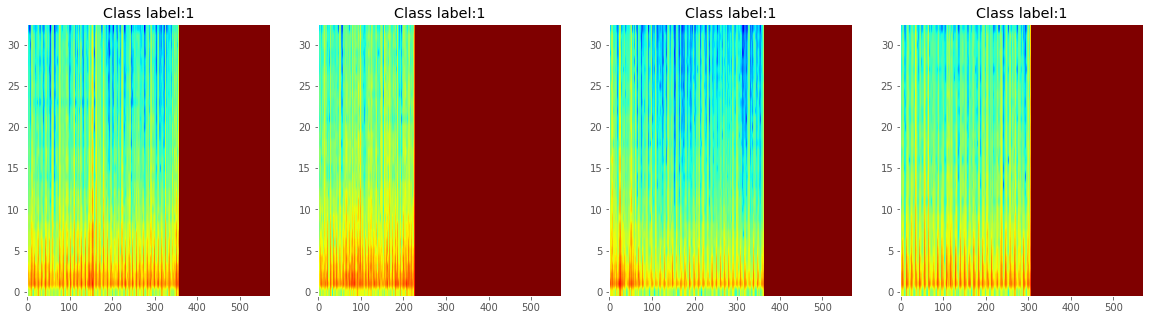

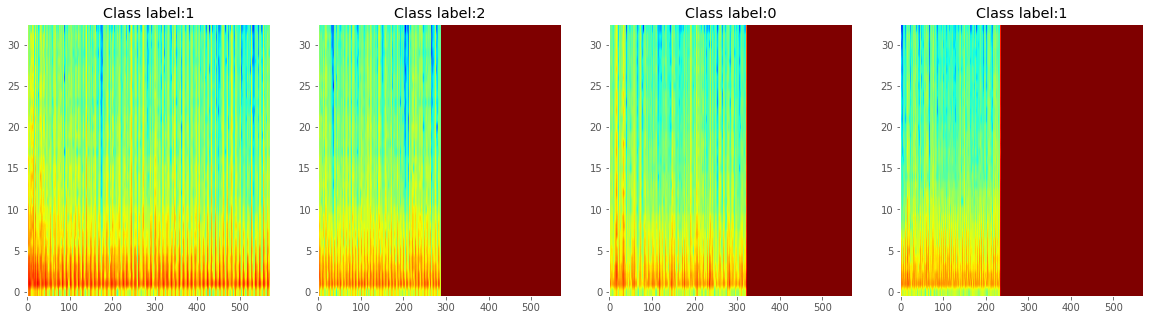

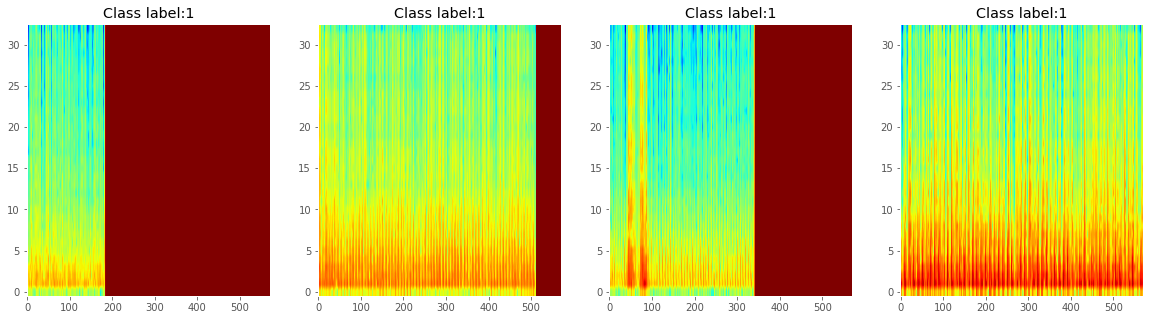

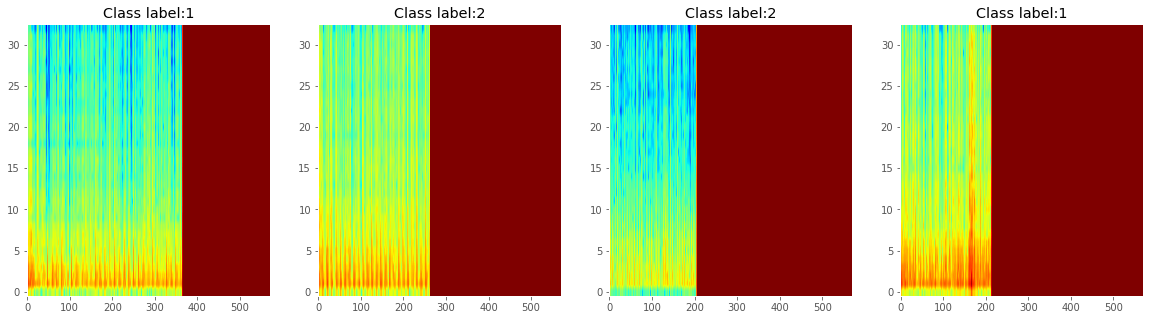

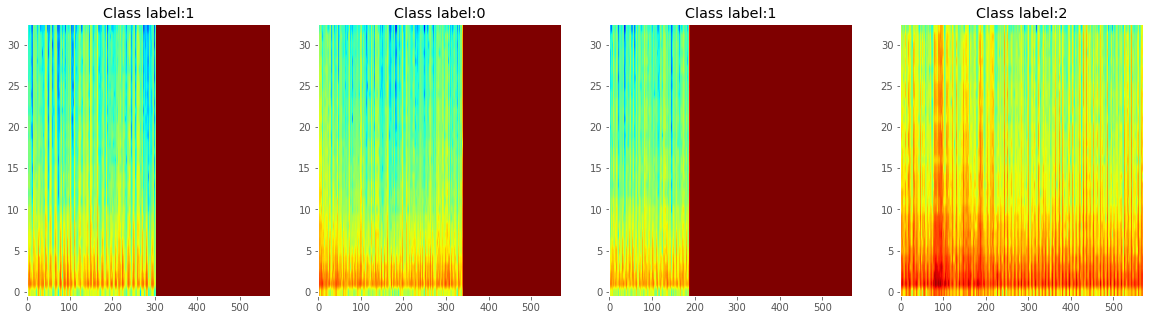

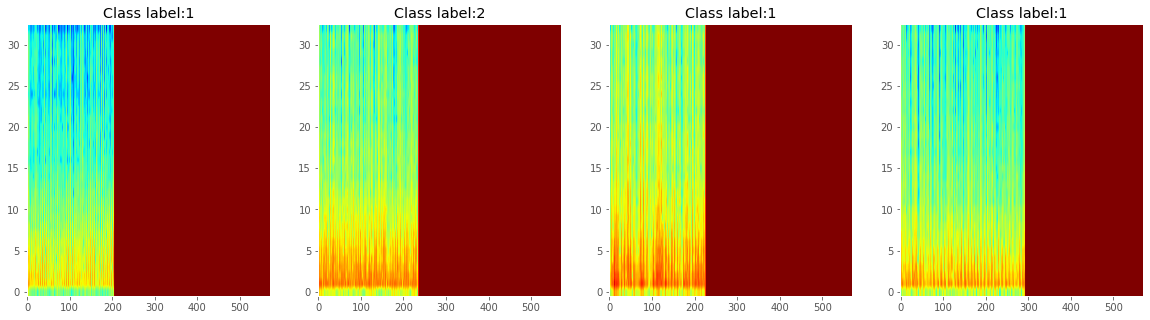

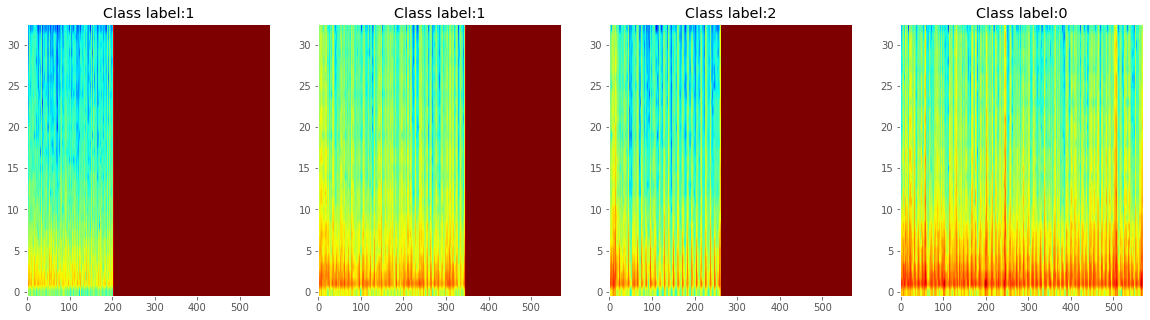

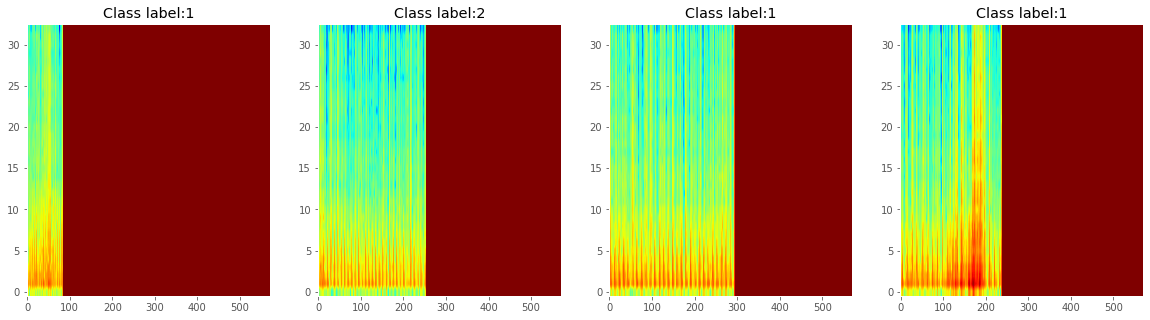

In [18]:
def imshow_batch(X, y, batch_idx):
    
    batch_labels = ['Class label:' + str(np.argmax(y[idx,])) for idx in batch_idx]
    #batch_labels = ['Class label:' + str(np.argmax(y[idx,])[0]) for idx in batch_idx]

    fig, ax = plt.subplots(1, len(batch_idx), figsize = (20, 5))

    for i, idx in enumerate(batch_idx):
    
        ax[i].imshow(X[idx, :, :, 0].transpose(), cmap = 'jet', aspect = 'auto')
        ax[i].grid(False)
        #ax[i].axis('off')
        ax[i].invert_yaxis()
        ax[i].set(title = batch_labels[i])
    
    plt.show()
        
    return fig
print(len(y))
x2 = 0
for i in range(8):
    x1 = x2
    x2 = x2 + 4
    batch_idx = np.arange(x1,x2)
    fig = imshow_batch(X, y, batch_idx)
    plt.show()

### Define the model ###

In [9]:
# Convolutional blocks
def conv2d_block(model, depth, layer_filters, filters_growth, 
                 strides_start, strides_end, input_shape, first_layer = False):
    
    ''' Convolutional block. 
    depth: number of convolutional layers in the block (4)
    filters: 2D kernel size (32)
    filters_growth: kernel size increase at the end of block (32)
    first_layer: provide input_shape for first layer'''
    
    # Fixed parameters for convolution
    conv_parms = {'kernel_size': (3, 3),
                  'padding': 'same',
                  'dilation_rate': (1, 1),
                  'activation': None,
                  'data_format': 'channels_last',
                  'kernel_initializer': 'glorot_normal'}

    for l in range(depth):

        if first_layer:
            
            # First layer needs an input_shape 
            model.add(layers.Conv2D(filters = layer_filters,
                                    strides = strides_start,
                                    input_shape = input_shape, **conv_parms))
            first_layer = False
        
        else:
            # All other layers will not need an input_shape parameter
            if l == depth - 1:
                # Last layer in each block is different: adding filters and using stride 2
                layer_filters += filters_growth
                model.add(layers.Conv2D(filters = layer_filters,
                                        strides = strides_end, **conv_parms))
            else:
                model.add(layers.Conv2D(filters = layer_filters,
                                        strides = strides_start, **conv_parms))
        
        # Continue with batch normalization and activation for all layers in the block
        model.add(layers.BatchNormalization(center = True, scale = True))
        model.add(layers.Activation('relu'))
    
    return model

def MeanOverTime():
    lam_layer = layers.Lambda(lambda x: K.mean(x, axis=1), output_shape=lambda s: (1, s[2]))
    return lam_layer

In [19]:
# Define the model
# Model parameters
filters_start = 32 # Number of convolutional filters
layer_filters = filters_start # Start with these filters
filters_growth = 32 # Filter increase after each convBlock
strides_start = (1, 1) # Strides at the beginning of each convBlock
strides_end = (2, 2) # Strides at the end of each convBlock
depth = 4 #12 Number of convolutional layers in each convBlock
n_blocks = 6 # Number of ConBlocks
n_channels = 1 # Number of color channgels
input_shape = (*dim, n_channels) # input shape for first layer


model = Sequential()

for block in range(n_blocks):

    # Provide input only for the first layer
    if block == 0:
        provide_input = True
    else:
        provide_input = False
    
    model = conv2d_block(model, depth,
                         layer_filters,
                         filters_growth,
                         strides_start, strides_end,
                         input_shape,
                         first_layer = provide_input)
    
    # Increase the number of filters after each block
    layer_filters += filters_growth



# Remove the frequency dimension, so that the output can feed into LSTM
# Reshape to (batch, time steps, filters)
model.add(layers.Reshape((-1, 224)))
#model.add(layers.core.Masking(mask_value = 0.0))
#model.add(MeanOverTime())

# Alternative: Replace averaging by LSTM

# Insert masking layer to ignore zeros
#model.add(layers.core.Masking(mask_value = 0.0))

# Add LSTM layer with 3 neurons
model.add(layers.LSTM(200))
model.add(layers.Flatten())

# And a fully connected layer for the output
model.add(layers.Dense(4, activation='sigmoid', kernel_regularizer = regularizers.l2(0.1)))


model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 570, 33, 32)       320       
_________________________________________________________________
batch_normalization_24 (Batc (None, 570, 33, 32)       128       
_________________________________________________________________
activation_24 (Activation)   (None, 570, 33, 32)       0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 570, 33, 32)       9248      
_________________________________________________________________
batch_normalization_25 (Batc (None, 570, 33, 32)       128       
_________________________________________________________________
activation_25 (Activation)   (None, 570, 33, 32)       0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 570, 33, 32)      

In [11]:
# Compile the model and run a batch through the network
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=0.001),
              metrics=['acc'])

In [12]:
history = model.fit_generator(generator = train_generator,
                              #steps_per_epoch = 10,
                              epochs = 10,#50,
                              validation_data = val_generator,
                              verbose=1)
                              #validation_steps = 10)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
10/10 [==============================] - 48s 5s/step - loss: 1.7580 - acc: 0.5781 - val_loss: 1.9317 - val_acc: 0.6438
Epoch 2/10
10/10 [==============================] - 55s 6s/step - loss: 1.5745 - acc: 0.6000 - val_loss: 1.7542 - val_acc: 0.6375
Epoch 3/10
10/10 [==============================] - 54s 5s/step - loss: 1.4709 - acc: 0.6062 - val_loss: 1.6006 - val_acc: 0.6375
Epoch 4/10
10/10 [==============================] - 54s 5s/step - loss: 1.3910 - acc: 0.6062 - val_loss: 1.4861 - val_acc: 0.6375
Epoch 5/10
10/10 [==============================] - 54s 5s/step - loss: 1.3214 - acc: 0.6031 - val_loss: 1.3853 - val_acc: 0.6313
Epoch 6/10
10/10 [==============================] - 54s 5s/step - loss: 1.2686 - acc: 0.6000 - val_loss: 1.3287 - val_acc: 0.6250
Epoch 7/10
10/10 [==============================] - 56s 6s/step - loss: 1.1987 - acc: 0.6062 - val_loss: 1.2530 - val_acc: 0.6375
Epoch 8/10
10/

In [13]:
df = pd.DataFrame(history.history)
df.head()
df.to_csv('demo_history.csv')

In [14]:
df

,loss,acc,val_loss,val_acc
0,1.758038,0.578125,1.931741,0.64375
1,1.574462,0.600000,1.754172,0.63750
2,1.470907,0.606250,1.600646,0.63750
3,1.390980,0.606250,1.486066,0.63750
4,1.321393,0.603125,1.385344,0.63125
5,1.268605,0.600000,1.328666,0.62500
6,1.198706,0.606250,1.253029,0.63750
7,1.172235,0.600000,1.193051,0.64375
8,1.149139,0.587500,1.216375,0.63750
9,1.094081,0.612500,1.137885,0.63750


<AxesSubplot:>

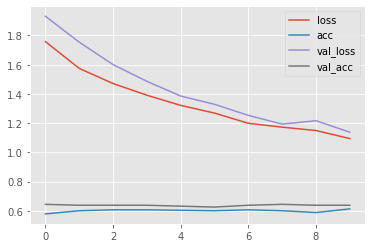

In [15]:
df.plot()

## Approximate Entropy

Approximate Entropy is explained clearly in this wikipedia link [AppEn](https://en.wikipedia.org/wiki/Approximate_entropy#cite_note-7). But here I would like to explain my own version of this algorithm to compute entropy of a continous time series signal. 

#### Assumptions
1. The upper and lower bound of the signal are known before hand (U an L)
2. An ideal subsequence of the signal is given (of length N)


## Proceedure
1. Divide the ideal subsequence into meaning full intervals (1...R intervals).
2. Using value counts in each interval Ci, compute the probability of a value falling into a given interval: Ci/N for 1 <= i <= R
2. Partition the time series signal into subsequences of length N
3. For each subsequence Sj: $Entropy(Sj) = -(1/N)*sum(logarithm ( Ci/N))$*v* where Ci is the interval on which a record v falls into.
4. Entropy of the time series would be abs(Entropy(Ideal) - AVG(Entropy(S1..j))

The advantage of this approach is that the computation is not affected by some phase shifts that occure frequently in ECG signals. That is, using distance between sequences to compute entropy of a correct but shifted signal with respect to a given sequence would result in higher entropy values. But using the approach expressed above, this problem doesn't occur.